In [ ]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split #split data
from sklearn.preprocessing import OneHotEncoder, StandardScaler #encode cat, scale numbers
from sklearn.compose import ColumnTransformer #apply different transforms to columns
from sklearn.pipeline import Pipeline #chain steps together
from sklearn.linear_model import LogisticRegression #basline model
from sklearn.calibration import CalibratedClassifierCV #probability calibration
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score, balanced_accuracy_score, brier_score_loss)

import matplotlib.pyplot as plt #calibration plot

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False


Cell 2- Columns & rule functions

In [ ]:
#features
NUM_COLS = [
    "serving_g", "calories", "carbs_g", "fiber_g", "sugar_g", "added_sugar_g",
    "sugar_alcohols_g", "protein_g", "fat_g", "sodium_mg", "net_carbs_g"
]

CAT_COLS = ["category"] #cereal, bread, snack, drink, dairy, grain


# --- Helper to compute derived feature ---
def compute_net_carbs(row):
    """
    net_carbs_g = carbs_g - fiber_g - sugar_alcohols_g
    Why: net carbs approximate carbs that meaningfully impact blood sugar.
    """
    carbs = max(float(row.get("carbs_g", 0) or 0), 0.0)
    fiber = max(float(row.get("fiber_g", 0) or 0), 0.0)
    sugar_alc = max(float(row.get("sugar_alcohols_g", 0) or 0), 0.0)
    return max(carbs - fiber - sugar_alc, 0.0)  # keep non-negative

# --- Rules: assign points + human-readable reasons ---
def rule_points_and_reasons(row):
    """
    Returns (points, [reason strings]).
    Positive points increase risk; negative points protect.
    """
    pts, reasons = 0, []
    net = row.get("net_carbs_g", compute_net_carbs(row))

    if net > 20:
        pts += 2
        reasons.append(f"High net carbs ({net:.1f}g > 20g)")

    added = float(row.get("added_sugar_g", 0) or 0)
    if added >= 8:
        pts += 2
        reasons.append(f"High added sugar ({added:.1f}g ≥ 8g)")

    sodium = float(row.get("sodium_mg", 0) or 0)
    if sodium >= 500:
        pts += 1
        reasons.append(f"High sodium ({sodium:.0f}mg ≥ 500mg)")

    fiber = float(row.get("fiber_g", 0) or 0)
    if fiber >= 5:
        pts -= 2
        reasons.append(f"Protective fiber ({fiber:.1f}g ≥ 5g)")

    protein = float(row.get("protein_g", 0) or 0)
    if protein >= 12:
        pts -= 1
        reasons.append(f"Protein helps satiety ({protein:.1f}g ≥ 12g)")

    return pts, reasons

def _val(row, key):
    v = row.get(key)
    # Keep None to detect "not listed" in reasons, but return 0.0 for math when needed.
    return None if v is None else float(v)

def human_reasons(row):
    """
    Use numeric values for thresholds, but show label-faithful strings
    (e.g., '<1g', '0g', '120mg') from row['__display'] where available.
    """
    reasons = []
    disp = row.get("__display", {}) or {}

    # Net carbs (always numeric display)
    net = row.get("net_carbs_g", compute_net_carbs(row))
    reasons.append(
        f"High net carbs ({net:.1f}g > 20g)" if net > 20
        else f"Net carbs within target ({net:.1f}g ≤ 20g)"
    )

    # Added sugar
    added_v = row.get("added_sugar_g")
    added_txt = disp.get("added_sugar_g") or ("not listed" if added_v is None else f"{float(added_v):.1f}g")
    if added_v is None:
        reasons.append("Added sugar not listed")
    elif float(added_v) >= 8:
        reasons.append(f"High added sugar ({added_txt} ≥ 8g)")
    else:
        reasons.append(f"Low added sugar ({added_txt})")

    # Sodium (mg)
    sodium_v = row.get("sodium_mg")
    sodium_txt = disp.get("sodium_mg") or ("not listed" if sodium_v is None else f"{int(round(float(sodium_v)))}mg")
    if sodium_v is None:
        reasons.append("Sodium not listed")
    else:
        s = float(sodium_v)
        if s >= 500:
            reasons.append(f"High sodium ({sodium_txt} ≥ 500mg)")
        elif s <= 140:
            reasons.append(f"Low sodium ({sodium_txt} ≤ 140mg)")
        else:
            reasons.append(f"Moderate sodium ({sodium_txt} < 500mg)")

    # Fiber
    fiber_v = row.get("fiber_g")
    fiber_txt = disp.get("fiber_g") or ("not listed" if fiber_v is None else f"{float(fiber_v):.1f}g")
    if fiber_v is None:
        reasons.append("Fiber not listed (some labels show '<1g' for trace amounts)")
    elif float(fiber_v) >= 5:
        reasons.append(f"Good fiber ({fiber_txt} ≥ 5g)")
    else:
        reasons.append(f"Low fiber ({fiber_txt} < 5g)")

    # Protein
    protein_v = row.get("protein_g")
    protein_txt = disp.get("protein_g") or ("not listed" if protein_v is None else f"{float(protein_v):.1f}g")
    if protein_v is None:
        reasons.append("Protein not listed")
    elif float(protein_v) >= 12:
        reasons.append(f"Higher protein ({protein_txt} ≥ 12g)")
    else:
        reasons.append(f"Moderate protein ({protein_txt} < 12g)")

    return reasons

def data_notes(row: dict):
    """
    Responsible, label-aware notes that reuse DISPLAY_RULES and __display:
    - If 'not listed': explain real labels sometimes show '<1g' or '<5mg'.
    - If '<X': clarify it's inferred from per-100g × serving, not directly listed.
    """
    disp = row.get("__display", {}) or {}
    notes = []
    for field, rule in DISPLAY_RULES.items():
        shown = disp.get(field)
        label = rule.get("label", field)
        unit, lt = rule["unit"], rule["lt"]

        if shown == "not listed":
            # sodium commonly uses '<5mg'; others '<1g'
            notes.append(
                f"{label}: source didn’t include a per-serving value. "
                f"Some packages print '<{lt}{unit}' for trace; we show that when per-100g data supports it."
            )
        elif isinstance(shown, str) and shown.startswith("<"):
            notes.append(f"{label}: “{shown}” inferred from per-100g × serving size.")
    return notes


def weak_label(row):
    """
    Final weak label: risky(1) if total points ≥ 2 else ok(0).
    Why: converts the rule score into a binary label to train a model.
    """
    pts, _ = rule_points_and_reasons(row)
    return 1 if pts >= 2 else 0

Cell 3: Generate Demo Data

In [ ]:
rng = np.random.default_rng(42)
N = 1000
categories = ["cereal", "bread", "snack", "drink", "dairy", "grain"]

df = pd.DataFrame({
    "name": [f"Product {i}" for i in range(N)],
    "brand": [f"Brand {rng.integers(1,50)}" for _ in range(N)],
    "upc": [str(100000000000 + int(rng.integers(0,9e11))) for _ in range(N)],
    "source": "synthetic",
    "created_at": pd.Timestamp("2025-09-01"),
    "category": rng.choice(categories, size=N),
    "serving_g": rng.integers(30, 80, size=N).astype(float),
    "calories": rng.integers(50, 400, size=N).astype(float),
    "carbs_g": rng.integers(0, 60, size=N).astype(float),
    "fiber_g": rng.integers(0, 12, size=N).astype(float),
    "sugar_g": rng.integers(0, 35, size=N).astype(float),
    "added_sugar_g": rng.integers(0, 20, size=N).astype(float),
    "sugar_alcohols_g": rng.integers(0, 12, size=N).astype(float),
    "protein_g": rng.integers(0, 30, size=N).astype(float),
    "fat_g": rng.integers(0, 25, size=N).astype(float),
    "sodium_mg": rng.integers(0, 1200, size=N).astype(float),
    "ingredients_text": ["wheat, sugar, salt, vitamins"] * N,
})

# Derive & label using rules
df["net_carbs_g"] = df.apply(compute_net_carbs, axis=1)
df["rule_points"], df["rule_reasons"] = zip(*df.apply(rule_points_and_reasons, axis=1))
df["label"] = df.apply(weak_label, axis=1)

df.head()


,name,brand,upc,source,created_at,category,serving_g,calories,carbs_g,fiber_g,...,added_sugar_g,sugar_alcohols_g,protein_g,fat_g,sodium_mg,ingredients_text,net_carbs_g,rule_points,rule_reasons,label
0,Product 0,Brand 5,763035119633,synthetic,2025-09-01,dairy,45.0,119.0,37.0,10.0,...,8.0,4.0,25.0,12.0,808.0,"wheat, sugar, salt, vitamins",23.0,2,"[High net carbs (23.0g > 20g), High added suga...",1
1,Product 1,Brand 38,897762598051,synthetic,2025-09-01,dairy,72.0,61.0,49.0,4.0,...,0.0,2.0,5.0,11.0,1097.0,"wheat, sugar, salt, vitamins",43.0,3,"[High net carbs (43.0g > 20g), High sodium (10...",1
2,Product 2,Brand 33,928951477565,synthetic,2025-09-01,grain,31.0,269.0,38.0,11.0,...,13.0,6.0,19.0,1.0,81.0,"wheat, sugar, salt, vitamins",21.0,1,"[High net carbs (21.0g > 20g), High added suga...",0
3,Product 3,Brand 22,553269632664,synthetic,2025-09-01,grain,52.0,289.0,35.0,6.0,...,9.0,7.0,15.0,2.0,392.0,"wheat, sugar, salt, vitamins",22.0,1,"[High net carbs (22.0g > 20g), High added suga...",0
4,Product 4,Brand 22,568247603266,synthetic,2025-09-01,dairy,70.0,320.0,28.0,4.0,...,15.0,3.0,18.0,14.0,317.0,"wheat, sugar, salt, vitamins",21.0,3,"[High net carbs (21.0g > 20g), High added suga...",1


Cell 4: Train/val/Test

In [ ]:
# Hold out ~200 rows as a "gold" test set
df_trainval, df_gold = train_test_split(
    df, test_size=200, random_state=7, stratify=df["label"]
)

# Split the remainder into train/val
df_train, df_val = train_test_split(
    df_trainval, test_size=0.2, random_state=7, stratify=df_trainval["label"]
)

len(df_train), len(df_val), len(df_gold), df["label"].mean()


(640, 160, 200, np.float64(0.374))

Cell 5: Preprocessing (impute, scale, encode)

In [ ]:
from sklearn.impute import SimpleImputer

X_train = df_train[NUM_COLS + CAT_COLS].copy()
y_train = df_train["label"].values

X_val = df_val[NUM_COLS + CAT_COLS].copy()
y_val = df_val["label"].values

X_gold = df_gold[NUM_COLS + CAT_COLS].copy()
y_gold = df_gold["label"].values

numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # fill NAs in numeric cols
    ("scaler", StandardScaler())                    # normalize scale
])

categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # fill missing category
    ("ohe", OneHotEncoder(handle_unknown="ignore"))        # robust OHE
])

pre = ColumnTransformer([
    ("num", numeric, NUM_COLS),
    ("cat", categorical, CAT_COLS),
])


Cell 6: Baseline model: Logistic Regression

In [ ]:
log_reg = Pipeline([
    ("pre", pre),                             # apply our preprocessor
    ("clf", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)                 # learn weights from data

# Evaluate on validation set
probs_val = log_reg.predict_proba(X_val)[:,1] # probability of "risky"
preds_val = (probs_val >= 0.5).astype(int)    # classify at threshold 0.5

def metrics_report(y_true, probs, preds):
    return {
        "AUROC": float(roc_auc_score(y_true, probs)),          # rank quality
        "AUPRC": float(average_precision_score(y_true, probs)),# handles class imbalance
        "F1": float(f1_score(y_true, preds)),                  # balances precision/recall
        "BalancedAcc": float(balanced_accuracy_score(y_true, preds)), # good with imbalance
        "Brier": float(brier_score_loss(y_true, probs)),       # probability calibration
    }

baseline_metrics = metrics_report(y_val, probs_val, preds_val)
baseline_metrics


{'AUROC': 0.927,
 'AUPRC': 0.8894663651841619,
 'F1': 0.8,
 'BalancedAcc': 0.8400000000000001,
 'Brier': 0.10710475939022732}

Cell 7: Calibrate probabilities → 0–100 score

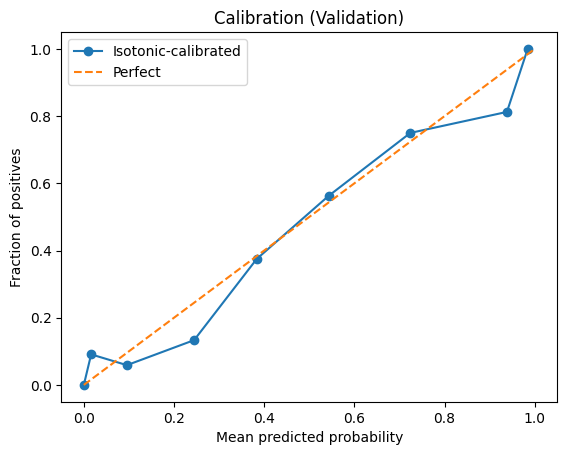

In [ ]:
base = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=1000))])
cal_clf = CalibratedClassifierCV(base, method="isotonic", cv=5)  # non-parametric calibration
cal_clf.fit(X_train, y_train)

probs_val_cal = cal_clf.predict_proba(X_val)[:,1]
preds_val_cal = (probs_val_cal >= 0.5).astype(int)
cal_metrics = metrics_report(y_val, probs_val_cal, preds_val_cal)
cal_metrics

from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_val, probs_val_cal, n_bins=10, strategy='quantile')
plt.plot(prob_pred, prob_true, marker='o', label='Isotonic-calibrated')
plt.plot([0,1],[0,1],'--', label='Perfect')
plt.xlabel('Mean predicted probability'); plt.ylabel('Fraction of positives')
plt.title('Calibration (Validation)'); plt.legend(); plt.show()


Cell 8: (Optional) XGBoost + SHAP

In [ ]:
if HAS_XGB:
    xgb_clf = Pipeline([
        ("pre", pre),
        ("xgb", xgb.XGBClassifier(
            n_estimators=300, max_depth=4, learning_rate=0.08,
            subsample=0.9, colsample_bytree=0.9,
            reg_lambda=1.0, objective="binary:logistic",
            eval_metric="logloss", n_jobs=4
        ))
    ])
    xgb_cal = CalibratedClassifierCV(xgb_clf, method="isotonic", cv=5)
    xgb_cal.fit(X_train, y_train)
    xgb_probs = xgb_cal.predict_proba(X_val)[:,1]
    xgb_preds = (xgb_probs >= 0.5).astype(int)
    {"XGB_metrics": metrics_report(y_val, xgb_probs, xgb_preds)}


Cell 9: Slice metrics (fairness/robustness by category)

In [ ]:
def slice_metrics(df_slice, model):
    Xs = df_slice[NUM_COLS + CAT_COLS]
    ys = df_slice["label"].values
    probs = model.predict_proba(Xs)[:,1]
    preds = (probs >= 0.5).astype(int)
    return metrics_report(ys, probs, preds)

for cat, d in df_val.groupby("category"):
    print(cat, "→", slice_metrics(d, cal_clf))


bread → {'AUROC': 0.9533333333333333, 'AUPRC': 0.9408119658119657, 'F1': 0.8421052631578947, 'BalancedAcc': 0.8666666666666667, 'Brier': 0.09473038907919389}
cereal → {'AUROC': 0.9142857142857143, 'AUPRC': 0.8211111111111111, 'F1': 0.5, 'BalancedAcc': 0.6642857142857144, 'Brier': 0.11949418937062455}
dairy → {'AUROC': 0.8636363636363636, 'AUPRC': 0.7364120727757092, 'F1': 0.6666666666666666, 'BalancedAcc': 0.75, 'Brier': 0.1504290764597193}
drink → {'AUROC': 1.0, 'AUPRC': 1.0, 'F1': 0.9411764705882353, 'BalancedAcc': 0.9666666666666667, 'Brier': 0.03901495073785655}
grain → {'AUROC': 0.935897435897436, 'AUPRC': 0.941249748108524, 'F1': 0.8461538461538461, 'BalancedAcc': 0.8564102564102565, 'Brier': 0.0912922073656151}
snack → {'AUROC': 0.8805668016194332, 'AUPRC': 0.8247069394842672, 'F1': 0.7857142857142857, 'BalancedAcc': 0.8178137651821862, 'Brier': 0.14962143870033912}


Cell 10: Save the calibrated model

In [ ]:
import os
# (if not already imported earlier)
# import numpy as np
# import pandas as pd
# import joblib

ART_DIR = "artifacts"
os.makedirs(ART_DIR, exist_ok=True)
joblib.dump(cal_clf, os.path.join(ART_DIR, "model.joblib"))
joblib.dump({"num_cols": NUM_COLS, "cat_cols": CAT_COLS,
             "categories": sorted(df["category"].unique())},
            os.path.join(ART_DIR, "meta.joblib"))

def risk_score_from_prob(p: float) -> int:
    """Map probability to 0–100 integer score."""
    return int(round(100 * float(p)))

# --- UI helper (friendly 0/100 display) ---
def format_risk_display(prob: float) -> str:
    if prob is None:
        return "—"
    p = float(prob)
    if p < 0.005:   # <0.5%
        return "Very low (<1)"
    if p > 0.995:   # >99.5%
        return "Very high (>99)"
    return str(int(round(100 * p)))

def _format_display_value(v, unit: str) -> str:
    if v is None:
        return "not listed"
    try:
        v = float(v)
    except Exception:
        return "not listed"
    if unit == "mg":
        return f"{int(round(v))}mg"
    if unit == "kcal":
        return f"{int(round(v))}kcal"
    return f"{v:.1f}g"  # grams

def ensure_display(row: dict) -> dict:
    """
    If the item lacks the label-like __display map (e.g., manual samples),
    build a simple one from numeric fields using DISPLAY_RULES units.
    """
    disp = row.get("__display") or {}
    if disp:  # already present (e.g., barcode path) -> keep it
        return row

    new_disp = {}
    for field, rule in DISPLAY_RULES.items():
        new_disp[field] = _format_display_value(row.get(field), rule["unit"])
    row["__display"] = new_disp
    return row

def ensure_alt_group(row: dict) -> dict:
    """Default alt_group to category if missing (for manual/synth rows)."""
    if not row.get("alt_group"):
        row["alt_group"] = row.get("category")
    return row

# --- Drop-in replacement for make_alternatives (uses alt_group if available) ---
def make_alternatives(df_all: pd.DataFrame, this_row: dict, score_this: int, k: int = 3):
    """
    Same-category (or same alt_group) candidates with lower risk and >= fiber, ranked.
    If none (e.g., this item already has risk 0–5), allow same risk IF fiber and/or net carbs improve.
    Ranking: lowest risk_score, then highest fiber, then biggest net-carb reduction.
    """
    cat = this_row.get("category")
    group_key = this_row.get("alt_group") or cat

    # --- CHANGED: prefer same alt_group; fall back to same category ---
    if "alt_group" in df_all.columns:
        pool = df_all[df_all["alt_group"].fillna(df_all["category"]) == group_key].copy()
        if pool.empty:
            pool = df_all[df_all["category"] == cat].copy()
    else:
        pool = df_all[df_all["category"] == cat].copy()

    if pool.empty:
        return []

    # --- avoid self-suggesting by UPC or exact name+brand, before scoring ---
    upc = (this_row.get("upc") or "").strip()
    name = (this_row.get("name") or "").strip().lower()
    brand = (this_row.get("brand") or "").strip().lower()

    if "upc" in pool.columns and upc:
        pool = pool[pool["upc"].astype(str).fillna("") != upc]

    if {"name", "brand"}.issubset(pool.columns) and name and brand:
        pool = pool[
            ~(
                (pool["name"].str.lower().fillna("") == name) &
                (pool["brand"].str.lower().fillna("") == brand)
            )
        ]

    if pool.empty:
        return []

    # Ensure we can compare net carbs even if the column is missing
    if "net_carbs_g" not in pool.columns:
        pool["net_carbs_g"] = pool.apply(compute_net_carbs, axis=1)

    # Score pool
    Xp = pool[NUM_COLS + CAT_COLS]
    pool["risk_prob"] = cal_clf.predict_proba(Xp)[:, 1]
    pool["risk_score"] = (pool["risk_prob"] * 100).round().astype(int)
    pool["risk_display"] = pool["risk_prob"].apply(format_risk_display)

    fiber_this = float(this_row.get("fiber_g", 0) or 0)
    this_net = compute_net_carbs(this_row)

    # --- The original strict rule: lower risk AND >= fiber ---
    cand = pool[
        (pool["risk_score"] < score_this) &
        (pool["fiber_g"].fillna(0) >= fiber_this)
    ].copy()

    # --- Fallback only when item already very low risk (<=5) ---
    if cand.empty and score_this <= 5:
        cand = pool[
            (pool["risk_score"] <= score_this) &
            (
                (pool["fiber_g"].fillna(0) > fiber_this) |
                (pool["net_carbs_g"] < this_net)
            )
        ].copy()

    if cand.empty:
        return []

    # Rank: lowest risk, then highest fiber, then biggest net-carb reduction
    cand["delta_net"] = this_net - cand["net_carbs_g"].astype(float)  # positive = improvement
    cand = cand.sort_values(
        by=["risk_score", "fiber_g", "delta_net"],
        ascending=[True, False, True]
    ).head(k)

    tiers = ["Good", "Better", "Best"]
    out = []
    for i, (_, r) in enumerate(cand.iterrows()):
        why_bits = []
        if r["net_carbs_g"] < this_net:
            why_bits.append(f"-{(this_net - r['net_carbs_g']):.0f}g net carbs")
        if r["fiber_g"] > fiber_this:
            why_bits.append(f"+{(r['fiber_g'] - fiber_this):.0f}g fiber")

        out.append({
            "tier": tiers[min(i, 2)],
            "name": r.get("name", f"Alt {i+1}"),
            "brand": r.get("brand"),
            "category": r["category"],
            "risk_score": int(r["risk_score"]),                 # for logic
            "risk_display": r["risk_display"],                  # for UI
            "why": ", ".join(why_bits) if why_bits else "Lower risk in same category"
        })

    return out

Cell 10B: Define the scorer

In [ ]:
def score_item(item: dict, df_candidates: pd.DataFrame = None) -> dict:
    """
    Core pipeline for one food:
    - derive net carbs
    - get calibrated P(risky) → 0–100 score
    - rules → human reasons
    - alternatives within same group/category
    - add data_notes explaining 'not listed' and '<X' cases
    """
    row = item.copy()
    row["net_carbs_g"] = compute_net_carbs(row)

    # label-like strings & swap grouping
    row = ensure_display(row)
    row = ensure_alt_group(row)

    # model prob → 0–100 risk
    x = pd.DataFrame([{k: row.get(k, np.nan) for k in (NUM_COLS + CAT_COLS)}])
    prob = float(cal_clf.predict_proba(x)[0,1])
    risk = int(round(100 * prob))

    # explanations
    pts, _ = rule_points_and_reasons(row)  # keep for debug/labels
    reasons = human_reasons(row)
    notes = data_notes(row)

    # swaps from same alt_group (fallback to category if candidates lack it)
    candidates = df if df_candidates is None else df_candidates
    if "alt_group" not in candidates.columns:
        candidates = candidates.copy()
        candidates["alt_group"] = candidates["category"]

    alts = make_alternatives(candidates, row, risk, k=3)

    return {
        "item_name": row.get("name"),
        "item_brand": row.get("brand"),
        "item_category": row.get("category"),
        "risk_score": risk,                         # numeric 0–100 (keep as-is)
        "risk_display": format_risk_display(prob),  # friendly display
        "prob_risky": prob,
        "rule_points": pts,
        "reasons": reasons,
        "alternatives": alts,
        "display": row.get("__display", {}),
        "notes": notes
}

# Example validation check
sample = {
  "name":"Frosted Cereal","category":"cereal","serving_g":40,
  "carbs_g":37,"fiber_g":3,"sugar_alcohols_g":0,
  "added_sugar_g":10,"sodium_mg":240,"protein_g":3,"calories":160,
  "sugar_g":14, "fat_g":2
}
score_item(sample)

{'item_name': 'Frosted Cereal',
 'item_brand': None,
 'item_category': 'cereal',
 'risk_score': 62,
 'risk_display': '62',
 'prob_risky': 0.6187572707507201,
 'rule_points': 4,
 'reasons': ['High net carbs (34.0g > 20g)',
  'High added sugar (10.0g ≥ 8g)',
  'Moderate sodium (240mg < 500mg)',
  'Low fiber (3.0g < 5g)',
  'Moderate protein (3.0g < 12g)'],
 'alternatives': [{'tier': 'Good',
   'name': 'Product 790',
   'brand': 'Brand 5',
   'category': 'cereal',
   'risk_score': 0,
   'risk_display': 'Very low (<1)',
   'why': '-1g net carbs, +8g fiber'},
  {'tier': 'Better',
   'name': 'Product 364',
   'brand': 'Brand 6',
   'category': 'cereal',
   'risk_score': 0,
   'risk_display': 'Very low (<1)',
   'why': '-4g net carbs, +8g fiber'},
  {'tier': 'Best',
   'name': 'Product 944',
   'brand': 'Brand 7',
   'category': 'cereal',
   'risk_score': 0,
   'risk_display': 'Very low (<1)',
   'why': '-5g net carbs, +8g fiber'}],
 'display': {'carbs_g': '37.0g',
  'fiber_g': '3.0g',
  'sug

Cell 11: Evaluate on the held-out “gold” set

In [ ]:
probs_gold = cal_clf.predict_proba(X_gold)[:,1]
preds_gold = (probs_gold >= 0.5).astype(int)
{
    "GOLD": {
        "AUROC": roc_auc_score(y_gold, probs_gold),
        "AUPRC": average_precision_score(y_gold, probs_gold),
        "F1": f1_score(y_gold, preds_gold),
        "BalancedAcc": balanced_accuracy_score(y_gold, preds_gold),
        "Brier": brier_score_loss(y_gold, probs_gold),
    }
}

{'GOLD': {'AUROC': 0.94096,
  'AUPRC': 0.9110176181167191,
  'F1': 0.8163265306122449,
  'BalancedAcc': 0.8520000000000001,
  'Brier': 0.09541987913696232}}

Cell 12: (Optional) Barcode lookup cell for Jupyter

In [ ]:
# ================= Open Food Facts fetch + dataset builder + purifier (one cell) =================
import re, os, time, json, requests, pandas as pd, numpy as np
from datetime import datetime, timezone
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# ---------------------------------------------------------------------------------
# Config / constants
# ---------------------------------------------------------------------------------
OFF_URL = "https://world.openfoodfacts.org/api/v2/product/{barcode}.json"
RAW_CSV   = "data/products_off.csv"
CLEAN_CSV = "data/products_off_clean.csv"
PER_GROUP_TARGET = 35

# Display rules (units + trace thresholds)
DISPLAY_RULES = {
    "carbs_g":          {"label": "Carbs",          "bases": ["carbohydrates"],                             "unit": "g",   "lt": 1},
    "fiber_g":          {"label": "Fiber",          "bases": ["fiber","fibre"],                              "unit": "g",   "lt": 1},
    "sugar_g":          {"label": "Total sugar",    "bases": ["sugars"],                                     "unit": "g",   "lt": 1},
    "added_sugar_g":    {"label": "Added sugar",    "bases": ["added-sugars","added_sugars"],                "unit": "g",   "lt": 1},
    "sugar_alcohols_g": {"label": "Sugar alcohols", "bases": ["polyols","sugar-alcohols","sugar_alcohols"], "unit": "g",   "lt": 1},
    "protein_g":        {"label": "Protein",        "bases": ["proteins"],                                   "unit": "g",   "lt": 1},
    "fat_g":            {"label": "Fat",            "bases": ["fat"],                                        "unit": "g",   "lt": 1},
    "sodium_mg":        {"label": "Sodium",         "bases": ["sodium"],                                     "unit": "mg",  "lt": 5},
}

# multi-tag search space per alt_group (broad but specific)
OFF_TAGS_MULTI = {
    "oats":          ["oats"],
    "rice":          ["rice"],
    "quinoa":        ["quinoa"],
    "pasta-noodles": ["pasta","noodles","spaghetti","penne","ramen","udon","soba","macaroni"],
    "cereal":        ["breakfast-cereals","cereals"],
    "nuts-seeds":    ["nuts","nuts-and-seeds","seeds","almonds","cashews","peanuts","pistachios","walnuts","hazelnuts","pecans","macadamia","trail-mix"],
    "ice-cream":     ["ice-creams","ice-cream","frozen-desserts"],
    "bread":         ["breads","bread","bakery","bagels","tortillas","flatbreads","wraps","buns","rolls","pita","naan","ciabatta"],
    "drink":         ["beverages","drinks","soft-drinks","juices","water"],
}

# canonical category for each alt_group
_CANON_CATEGORY_FOR_GROUP = {
    "oats":"grain","rice":"grain","quinoa":"grain","pasta-noodles":"grain",
    "cereal":"cereal","granola":"cereal",
    "nuts-seeds":"nut","bread":"bread","ice-cream":"dessert","drink":"drink",
}

# high-confidence positive name patterns for each alt_group
_ALT_KEYWORDS = {
    "oats":          [r"\boat(s|meal)?\b", r"\bgranola\b", r"\bmuesli\b", r"\bporridge\b"],
    "rice":          [r"\brice\b", r"\bbasmati\b", r"\bjasmine\b", r"\bwild[- ]?rice\b"],
    "quinoa":        [r"\bquinoa\b"],
    "pasta-noodles": [r"\bpasta\b", r"\bnoodle(s)?\b", r"\bspaghetti\b", r"\bpenne\b", r"\bmacaroni\b", r"\bramen\b", r"\budon\b", r"\bsoba\b"],
    "cereal":        [r"\bcereal(s)?\b"],
    "nuts-seeds":    [r"\bnut(s)?\b", r"\bseed(s)?\b", r"\balmond(s)?\b", r"\bcashew(s)?\b", r"\bpeanut(s)?\b",
                      r"\bpistachio(s)?\b", r"\bwalnut(s)?\b", r"\bhazelnut(s)?\b", r"\bpecan(s)?\b", r"\bmacadamia\b",
                      r"\btrail[- ]?mix\b", r"\bsunflower\b", r"\bpumpkin\b", r"\bchia\b", r"\bflax\b"],
    "bread":         [r"\bbread(s)?\b", r"\bbagel(s)?\b", r"\btortilla(s)?\b", r"\bflatbread(s)?\b", r"\bwrap(s)?\b",
                      r"\bbun(s)?\b", r"\broll(s)?\b", r"\bpita\b", r"\bnaan\b", r"\bciabatta\b"],
    "ice-cream":     [r"\bice[- ]?cream\b", r"\bfrozen dessert\b"],
    "drink":         [r"\bbeverage(s)?\b", r"\bdrink(s)?\b", r"\bwater\b", r"\bjuice(s)?\b", r"\bsoft[- ]?drink(s)?\b", r"\bsoda(s)?\b"],
}

# obvious negatives (to kick out wrong items from a group)
_NEGATIVE_KEYWORDS = {
    "nuts-seeds":    [r"\b(curry|soup|sauce|beans?|lentils?|chili|ready[- ]?meal|microwave)\b", r"\bwater\b", r"\bdrink(s)?\b"],
    "bread":         [r"\bsoup\b", r"\bnoodle(s)?\b", r"\brice\b", r"\bjuice\b"],
    "oats":          [r"\bnoodle(s)?\b", r"\bjuice\b", r"\bsoup\b", r"\brice\b"],
    "rice":          [r"\bnoodle(s)?\b", r"\boat(s|meal)?\b", r"\bjuice\b"],
    "quinoa":        [r"\bsoup\b", r"\bjuice\b"],
    "pasta-noodles": [r"\brice\b", r"\bjuice\b", r"\bsoup\b"],
    "cereal":        [r"\bsoup\b", r"\bnoodle(s)?\b", r"\brice\b"],
    "ice-cream":     [r"\bsoup\b", r"\bwater\b", r"\bnoodle(s)?\b"],
    "drink":         [r"\bsoup\b", r"\bnoodle(s)?\b", r"\bpasta\b", r"\brice\b", r"\bice[- ]?cream\b"],
}

TARGET_GROUPS = set(OFF_TAGS_MULTI.keys())

# ---------------------------------------------------------------------------------
# Safe lower-casing / text helpers (FIX for AttributeError on NaN)
# ---------------------------------------------------------------------------------
def _safe_lower_s(x) -> str:
    """Return lowercase string or empty string for None/NaN/non-strings."""
    try:
        if isinstance(x, str):
            return x.lower()
        if x is None:
            return ""
        if isinstance(x, float) and (np.isnan(x)):
            return ""
        return str(x).lower()
    except Exception:
        return ""

def _text_has_any(patterns, *texts) -> bool:
    joined = " ".join([_safe_lower_s(t) for t in texts if _safe_lower_s(t)])
    return any(re.search(p, joined) for p in patterns)

# ---------------------------------------------------------------------------------
# Core helpers (display / parsing / net carbs)
# ---------------------------------------------------------------------------------
def _extract_cats(p):
    raw = p.get("categories_hierarchy") or p.get("categories_tags") or []
    cats = []
    for c in raw:
        try:
            s = str(c).strip().lower()
            if not s: continue
            if ":" in s: s = s.split(":")[-1]
            cats.append(s)
        except Exception:
            continue
    return cats

def _parse_serving_g(product):
    ss = (product.get("serving_size") or "").lower()
    m = re.search(r"([\d\.]+)\s*(g|ml)\b", ss)
    if m:
        val, unit = float(m.group(1)), m.group(2)
        return val if unit == "g" else val  # ml≈g for liquids
    q = product.get("serving_quantity"); u = (product.get("serving_unit") or "").lower()
    if q is not None and u == "g":
        return float(q)
    return 100.0

def _get(n, base, serving_g, default=None):
    for key in (f"{base}_serving", f"{base}_per_serving"):
        if key in n and n[key] is not None:
            try: return float(n[key])
            except: pass
    v100 = n.get(f"{base}_100g")
    if v100 is not None:
        try: return float(v100) * (serving_g/100.0)
        except: pass
    v = n.get(base)
    if v is not None:
        try: return float(v) * (serving_g/100.0)
        except: pass
    return default

def _first(n, bases, serving_g, default=None):
    for b in bases:
        v = _get(n, b, serving_g, None)
        if v is not None:
            try: return float(v)
            except: pass
    return default

def _calories(n, sg):
    kcal = _first(n, ["energy-kcal","energy_kcal"], sg, None)
    if kcal is not None: return float(kcal)
    kj = _first(n, ["energy"], sg, None)
    return float(kj)*0.239006 if kj is not None else 0.0

def _sodium_mg(n, sg):
    unit = (n or {}).get("sodium_unit", "g")
    if (n or {}).get("sodium_serving") is not None:
        val = float(n["sodium_serving"]); return val*1000 if unit=="g" else val
    if (n or {}).get("sodium_100g") is not None:
        val = float(n["sodium_100g"])*(sg/100.0); return val*1000 if unit=="g" else val
    salt = _get(n, "salt", sg, None)
    if salt is not None: return float(salt)*0.393*1000
    return 0.0

def _per100_to_serving(val_100g: float, serving_g: float) -> float:
    return float(val_100g) * (serving_g / 100.0)

def _display_value(nutriments, bases, serving_g, serving_value, unit, lt_threshold):
    v100 = None
    for b in bases:
        k = f"{b}_100g"
        if k in nutriments and nutriments[k] is not None:
            try: v100 = float(nutriments[k]); break
            except: pass
    est_serv = None
    try:
        if v100 is not None and serving_g:
            if unit == "mg" and any(b == "sodium" for b in bases):
                unit_tag = nutriments.get("sodium_unit", "g")
                est = _per100_to_serving(v100, serving_g)
                est_serv = est * 1000.0 if unit_tag == "g" else est
            else:
                est_serv = _per100_to_serving(v100, serving_g)
    except: est_serv = None

    if serving_value is None:
        if est_serv is not None and 0 < est_serv < lt_threshold: return f"<{int(lt_threshold)}{unit}"
        return "not listed"
    try: v = float(serving_value)
    except: return "not listed"
    if v == 0.0:
        if est_serv is not None and 0 < est_serv < lt_threshold: return f"<{int(lt_threshold)}{unit}"
        return f"0{unit}"
    if unit == "mg":   return f"{int(round(v))}mg"
    if unit == "kcal": return f"{int(round(v))}kcal"
    return f"{v:.1f}g"

def _safe_float(x, default=0.0):
    try:
        return float(x) if x is not None else default
    except Exception:
        return default

def compute_net_carbs_local(row: dict) -> float:
    carbs = max(_safe_float(row.get("carbs_g"), 0.0), 0.0)
    fiber = max(_safe_float(row.get("fiber_g"), 0.0), 0.0)
    sugar_alc = max(_safe_float(row.get("sugar_alcohols_g"), 0.0), 0.0)
    return max(carbs - fiber - sugar_alc, 0.0)

# ---------------------------------------------------------------------------------
# Mapping rules (OFF -> category/alt_group)
# ---------------------------------------------------------------------------------
def _map_category_and_group(p):
    cats = _extract_cats(p)
    def has(*subs): return any(any(s in c for s in subs) for c in cats)

    if has("oat","oats","porridge","rolled-oats","oatmeal","granola","muesli"): return ("grain","oats")
    if has("rice","brown-rice","white-rice","basmati","jasmine","wild-rice"):    return ("grain","rice")
    if has("quinoa"):                                                             return ("grain","quinoa")
    if has("pasta","noodles","spaghetti","penne","macaroni","ramen","udon","soba"): return ("grain","pasta-noodles")

    if has("breakfast-cereals","cereals"):
        if has("granola","muesli"): return ("cereal","granola")
        return ("cereal","cereal")

    if has("bread","breads","bakery","loaves","bagel","bagels",
           "tortilla","tortillas","flatbread","flatbreads","wrap","wraps",
           "bun","buns","roll","rolls","pita","naan","ciabatta"):
        return ("bread","bread")

    if has("beverages","drinks","soft-drinks","sodas","juice","juices","water"):
        return ("drink","drink")

    if has("ice-cream","ice-creams","frozen-dessert","frozen-desserts"):
        return ("dessert","ice-cream")
    if has("dairies","dairy","milk","yogurt","cheese","cream"):
        return ("dairy","dairy")

    if has("nuts","nuts-and-seeds","almonds","cashews","peanuts","pistachios","walnuts","hazelnuts",
           "pecans","macadamia","seeds","sunflower-seeds","pumpkin-seeds","chia","flax",
           "trail-mix","nut-mix","seed-mix"):
        return ("nut","nuts-seeds")

    if has("snacks","chips","crisps","crackers","popcorn","bars"):
        return ("snack","snack")
    return ("snack","snack")

# ---------------------------------------------------------------------------------
# Robust HTTP session with retries
# ---------------------------------------------------------------------------------
def _make_session():
    s = requests.Session()
    retries = Retry(
        total=5, connect=4, read=4, backoff_factor=0.7,
        status_forcelist=(429,500,502,503,504),
        allowed_methods=frozenset(["GET"])
    )
    s.mount("https://", HTTPAdapter(max_retries=retries))
    s.mount("http://",  HTTPAdapter(max_retries=retries))
    s.headers.update({"User-Agent":"dianalysis/0.1 (educational demo)"})
    return s

SESSION = _make_session()
def _safe_get(url, params=None, timeout=30):
    return SESSION.get(url, params=params, timeout=timeout)

# ---------------------------------------------------------------------------------
# Fetch & normalize one product (adds pnns2, categories_all, ingredients_tags)
# ---------------------------------------------------------------------------------
_VALID_CODE_LEN = {8, 12, 13, 14}
def _looks_like_barcode(code: str) -> bool:
    c = (code or "").strip()
    return c.isdigit() and (len(c) in _VALID_CODE_LEN)

def fetch_and_normalize_off(barcode: str) -> dict:
    if not _looks_like_barcode(barcode):
        raise ValueError("bad barcode")
    r = _safe_get(OFF_URL.format(barcode=barcode), timeout=20)
    r.raise_for_status()
    data = r.json()
    if data.get("status") != 1:
        raise ValueError("Product not found")

    p = data["product"]; n = p.get("nutriments", {}) or {}
    sg = _parse_serving_g(p)
    category, alt_group = _map_category_and_group(p)
    cats = _extract_cats(p)

    features = {
        "name": p.get("product_name_en") or p.get("product_name") or barcode,
        "brand": (p.get("brands") or "").split(",")[0].strip() if p.get("brands") else None,
        "upc": barcode,
        "source": "openfoodfacts",
        "created_at": datetime.now(timezone.utc).isoformat(),

        "category": category,
        "alt_group": alt_group,
        "categories_all": "|".join(cats) if cats else None,
        "pnns2": p.get("pnns_groups_2") or p.get("pnns_groups_2_en") or None,
        "ingredients_tags": "|".join(p.get("ingredients_tags") or []) or None,

        "serving_g": float(sg),
        "calories": _calories(n, sg),

        "carbs_g":          _get(n, "carbohydrates", sg, None),
        "fiber_g":          _first(n, ["fiber","fibre"], sg, None),
        "sugar_g":          _get(n, "sugars", sg, None),
        "added_sugar_g":    _first(n, ["added-sugars","added_sugars"], sg, None),
        "sugar_alcohols_g": _first(n, ["polyols","sugar-alcohols","sugar_alcohols"], sg, None),
        "protein_g":        _get(n, "proteins", sg, None),
        "fat_g":            _get(n, "fat", sg, None),
        "sodium_mg":        _sodium_mg(n, sg),

        "ingredients_text": p.get("ingredients_text_en") or p.get("ingredients_text") or None,
    }

    disp = {}
    for field, rule in DISPLAY_RULES.items():
        disp[field] = _display_value(
            nutriments=n, bases=rule["bases"], serving_g=sg,
            serving_value=features.get(field), unit=rule["unit"], lt_threshold=rule["lt"]
        )
    features["__display"] = disp
    features["net_carbs_g"] = compute_net_carbs_local(features)
    return features

# ---------------------------------------------------------------------------------
# Listing utils
# ---------------------------------------------------------------------------------
def off_list_barcodes_for_tag(tag: str, limit=200, page_size=200,
                              country="United States", timeout=30, max_pages=80, sleep=0.25):
    out, page = [], 1
    while len(out) < limit and page <= max_pages:
        url = "https://world.openfoodfacts.org/cgi/search.pl"
        params = {
            "search_simple": 1, "action": "process", "json": 1,
            "page": page, "page_size": page_size,
            "fields": "code",
            "tagtype_0": "categories", "tag_contains_0": "contains", "tag_0": tag,
            "tagtype_1": "states", "tag_contains_1": "contains", "tag_1": "en:nutrition-facts-completed",
        }
        if country:
            params.update({"tagtype_2": "countries", "tag_contains_2": "contains", "tag_2": country})
        try:
            r = _safe_get(url, params=params, timeout=timeout)
            r.raise_for_status()
            prods = r.json().get("products", [])
        except requests.RequestException:
            prods = []
        if not prods:
            break
        for p in prods:
            code = str(p.get("code") or "").strip()
            if code and _looks_like_barcode(code):
                out.append(code)
            if len(out) >= limit:
                break
        page += 1
        time.sleep(sleep)
    seen, uniq = set(), []
    for c in out:
        if c not in seen:
            uniq.append(c); seen.add(c)
    return uniq

def off_list_codes_multi(tags, limit_per_tag, country="United States", timeout=30):
    all_codes = []
    for t in tags:
        all_codes += off_list_barcodes_for_tag(t, limit=limit_per_tag, country=country, timeout=timeout)
    seen, uniq = set(), []
    for c in all_codes:
        if c not in seen:
            uniq.append(c); seen.add(c)
    return uniq

# ---------------------------------------------------------------------------------
# Group acceptance / repair
# ---------------------------------------------------------------------------------
def _coerce_pair_for_group(feat: dict, target_group: str) -> dict:
    feat = dict(feat)
    feat["alt_group"] = target_group
    feat["category"]  = _CANON_CATEGORY_FOR_GROUP.get(target_group, feat.get("category"))
    return feat

def _belongs_to_group(feat: dict, target_group: str) -> bool:
    """Return True if this item really belongs to target_group."""
    if not target_group or target_group not in TARGET_GROUPS:
        return False

    ag = _safe_lower_s(feat.get("alt_group"))
    name = _safe_lower_s(feat.get("name"))
    ingr = _safe_lower_s(feat.get("ingredients_text"))
    cats_all = _safe_lower_s(feat.get("categories_all"))
    pnns2 = _safe_lower_s(feat.get("pnns2"))

    # negative kicks
    neg = _NEGATIVE_KEYWORDS.get(target_group, [])
    if _text_has_any(neg, name, ingr):
        return False

    # already labeled as group -> accept (unless negative hit caught above)
    if ag == target_group:
        return True

    # tags contain any of the group's OFF tags -> accept
    for t in OFF_TAGS_MULTI[target_group]:
        if t.lower() in cats_all:
            return True

    # name keywords -> accept
    if _text_has_any(_ALT_KEYWORDS.get(target_group, []), name):
        return True

    # pnns hints (lightweight)
    if target_group in ("cereal",) and ("breakfast cereals" in pnns2 or "cereals" in pnns2):
        return True
    if target_group in ("bread",) and ("bread" in pnns2):
        return True
    if target_group in ("ice-cream",) and ("ice creams" in pnns2 or "ice creams and sorbets" in pnns2):
        return True
    if target_group in ("drink",) and ("beverages" in pnns2 or "sweetened beverages" in pnns2 or "unsweetened beverages" in pnns2):
        return True
    if target_group in ("oats","rice","quinoa","pasta-noodles") and ("cereals" in pnns2 or "cereals and potatoes" in pnns2):
        return True
    if target_group == "nuts-seeds" and ("nuts" in pnns2):
        return True

    return False

def _fallback_group_from_text(name: str, ingredients: str, cats_list) -> tuple | None:
    """Infer (category, alt_group) from strong textual cues."""
    name_l = _safe_lower_s(name)
    cats_l = [ _safe_lower_s(c) for c in (cats_list or []) ]

    # scan in priority order
    for ag in ["nuts-seeds","bread","oats","rice","quinoa","pasta-noodles","cereal","ice-cream","drink"]:
        if _text_has_any(_ALT_KEYWORDS.get(ag, []), name_l) or any(t in " ".join(cats_l) for t in OFF_TAGS_MULTI[ag]):
            return (_CANON_CATEGORY_FOR_GROUP.get(ag, "snack"), ag)
    # last resort: drinks by name
    if re.search(r"\b(water|juice|beverage|drink|soda)\b", name_l):
        return ("drink","drink")
    return None

def _should_accept_into_group(feat: dict, target_group: str, tag_list: list) -> tuple[bool, dict]:
    """Gate for builder loop: keep only items we trust for this group; coerce pair if needed."""
    if _belongs_to_group(feat, target_group):
        return True, _coerce_pair_for_group(feat, target_group)

    cats_all = feat.get("categories_all") or ""
    name = feat.get("name") or ""
    ingr = feat.get("ingredients_text") or ""
    cats = cats_all.split("|") if isinstance(cats_all, str) else []
    fix = _fallback_group_from_text(name, ingr, cats)
    if fix:
        new_cat, new_ag = fix
        if new_ag == target_group:
            feat = _coerce_pair_for_group(feat, target_group)
            return True, feat
    return False, feat

# ---------------------------------------------------------------------------------
# Builder (resume/top-up)
# ---------------------------------------------------------------------------------
def build_off_dataset_per_group(tags_multi: dict, per_group=35, country="United States",
                                sleep=0.3, timeout=30, resume=True, csv_path=RAW_CSV):
    os.makedirs("data", exist_ok=True)
    if resume and os.path.exists(csv_path):
        df_out = pd.read_csv(csv_path, dtype={"upc": str})
        print(f"Resuming from {csv_path} (rows={len(df_out)})")
    else:
        df_out = pd.DataFrame()

    already = set(df_out.get("upc", pd.Series(dtype=str)).astype(str).tolist())

    for alt_group, tag_list in tags_multi.items():
        have = int((df_out["alt_group"] == alt_group).sum()) if not df_out.empty and "alt_group" in df_out.columns else 0
        need = max(0, per_group - have)
        print(f"Fetching {alt_group}… need {need} (have {have})")
        if need == 0:
            continue

        # US-first sweep
        codes = off_list_codes_multi(tag_list, limit_per_tag=max(need*4, 120), country=country, timeout=timeout)
        # Broaden to global if thin
        if len(codes) < need * 2:
            print("  Broadening to global…")
            codes = off_list_codes_multi(tag_list, limit_per_tag=max(need*5, 180), country=None, timeout=timeout) + codes

        # drop already-seen
        codes = [c for c in codes if c not in already]

        kept = 0
        sk_status0 = sk_http = sk_timeout = sk_other = sk_wronggroup = 0
        logged_other = 0

        for code in codes:
            if kept >= need:
                break
            try:
                feat = fetch_and_normalize_off(code)
                ok, feat = _should_accept_into_group(feat, alt_group, tag_list)
                if not ok:
                    sk_wronggroup += 1
                    continue

                if not feat.get("alt_group"):
                    feat["alt_group"] = feat.get("category")
                df_out = pd.concat([df_out, pd.DataFrame([feat])], ignore_index=True, sort=False)
                already.add(code)
                kept += 1
                if kept % 10 == 0:
                    df_out.to_csv(csv_path, index=False)
            except requests.ReadTimeout:
                sk_timeout += 1
            except requests.RequestException:
                sk_http += 1
            except ValueError:
                sk_status0 += 1
            except Exception as e:
                sk_other += 1
                if logged_other < 5:
                    print(f"   other error for code {code}: {type(e).__name__}: {e}")
                    logged_other += 1
            finally:
                time.sleep(sleep)

        print(f"  kept {kept} for {alt_group} | skips: wronggroup={sk_wronggroup}, status0={sk_status0}, http={sk_http}, timeout={sk_timeout}, other={sk_other}")
        df_out.to_csv(csv_path, index=False)

    print(f"Saved -> {csv_path}  | rows: {len(df_out)}")
    return df_out

# ---------------------------------------------------------------------------------
# Post-harvest purifier (repair + hard filter)
# ---------------------------------------------------------------------------------
def _reassign_group_row(row: pd.Series) -> pd.Series:
    ag  = _safe_lower_s(row.get("alt_group"))
    # If it doesn’t really belong, try to infer from text/tags and coerce
    if not _belongs_to_group(row, ag):
        name = row.get("name") or ""
        ingr = row.get("ingredients_text") or ""
        cats = row.get("categories_all") or ""
        cats = cats.split("|") if isinstance(cats, str) else []
        fix = _fallback_group_from_text(name, ingr, cats)
        if fix:
            new_cat, new_ag = fix
            row["alt_group"] = new_ag
            row["category"]  = new_cat
            ag = new_ag
    # enforce canonical category for the final group
    if ag in _CANON_CATEGORY_FOR_GROUP:
        row["category"] = _CANON_CATEGORY_FOR_GROUP[ag]
    return row

def purify_off_dataset(csv_in=RAW_CSV, csv_out=CLEAN_CSV):
    if not os.path.exists(csv_in):
        raise FileNotFoundError(f"Missing input file: {csv_in}")
    df = pd.read_csv(csv_in, dtype={"upc": str})
    before = len(df)

    # drop rows with missing UPC
    df = df[df["upc"].astype(str).str.strip().str.len() > 0].copy()

    # attempt repairs (row-wise)
    df = df.apply(_reassign_group_row, axis=1)

    # keep only rows that clearly belong to their own alt_group
    def _row_ok(r: pd.Series):
        ag = _safe_lower_s(r.get("alt_group"))
        return (ag in TARGET_GROUPS) and _belongs_to_group(r, ag)

    mask = df.apply(_row_ok, axis=1)
    dropped = int((~mask).sum())
    df_clean = df[mask].copy()

    # ensure net carbs exists
    if "net_carbs_g" not in df_clean.columns:
        df_clean["net_carbs_g"] = df_clean.apply(lambda r: compute_net_carbs_local(r), axis=1)

    os.makedirs("data", exist_ok=True)
    df_clean.to_csv(csv_out, index=False)
    print(f"Cleaned: kept {len(df_clean)}/{before} rows (dropped {dropped}). Saved -> {csv_out}")
    print("Counts by alt_group:", df_clean["alt_group"].value_counts().to_dict())
    return df_clean

# ---------------------------------------------------------------------------------
# Build + top-up + purify
# ---------------------------------------------------------------------------------
os.makedirs("data", exist_ok=True)
try:
    df_off_raw = build_off_dataset_per_group(
        OFF_TAGS_MULTI,
        per_group=PER_GROUP_TARGET,
        country="United States",
        sleep=0.3,
        timeout=30,
        resume=True,
        csv_path=RAW_CSV,
    )
except Exception as e:
    print("Builder failed:", e)

# Top-up missing groups globally (optional second pass)
try:
    cur = pd.read_csv(RAW_CSV, dtype={"upc": str}) if os.path.exists(RAW_CSV) else pd.DataFrame()
    counts = cur.get("alt_group", pd.Series(dtype=str)).value_counts() if not cur.empty else pd.Series(dtype=int)
    missing = {g: OFF_TAGS_MULTI[g] for g in OFF_TAGS_MULTI if counts.get(g, 0) < PER_GROUP_TARGET}
    if missing:
        print("Missing groups for top-up:", {g: f"{counts.get(g,0)}/{PER_GROUP_TARGET}" for g in missing})
        df_off_raw = build_off_dataset_per_group(
            missing,
            per_group=PER_GROUP_TARGET,
            country=None,          # global fallback
            sleep=0.35,
            timeout=30,
            resume=True,
            csv_path=RAW_CSV,
        )
except Exception as e:
    print("Top-up failed:", e)

# Purify
df_off = purify_off_dataset(RAW_CSV, CLEAN_CSV)
print("alt_group top (clean):", df_off.get("alt_group", pd.Series(dtype=str)).value_counts().head(20).to_dict())
print("category  top (clean):", df_off.get("category", pd.Series(dtype=str)).value_counts().head(20).to_dict())

# ---------------------------------------------------------------------------------
# Helpers: peek + score_by_barcode
# ---------------------------------------------------------------------------------
def peek_off_nutriments(barcode: str, base="https://world.openfoodfacts.org"):
    url = f"{base}/api/v2/product/{barcode}.json"
    r = _safe_get(url, timeout=20); r.raise_for_status()
    d = r.json()
    if d.get("status") != 1:
        print("Not found on Open Food Facts"); return None, None
    p = d["product"]; n = p.get("nutriments", {}) or {}
    print("Name:", p.get("product_name") or "(none)")
    print("Brands:", p.get("brands") or "(none)")
    print("Serving size:", p.get("serving_size") or "(none)")
    print("Category tags (first 5):", (p.get("categories_tags") or [])[:5])
    print("Nutriment keys (sample):", sorted(n.keys())[:25], "…")
    return p, n

def score_by_barcode(barcode: str, df_candidates: pd.DataFrame = None):
    """
    Normalize by barcode, then call the existing `score_item`.
    If score_item isn't defined yet, returns the normalized item (so you can inspect fields).
    """
    try:
        item = fetch_and_normalize_off(barcode)
    except Exception as e:
        return {"barcode": barcode, "error": f"lookup failed: {e}"}
    if "score_item" in globals():
        return score_item(item, df_candidates=(df_candidates if df_candidates is not None else df_off))
    return {"normalized_item": item, "note": "score_item() not defined in this kernel yet"}

Resuming from data/products_off.csv (rows=711)
Fetching oats… need 0 (have 64)
Fetching rice… need 0 (have 47)
Fetching quinoa… need 0 (have 36)
Fetching pasta-noodles… need 0 (have 38)
Fetching cereal… need 0 (have 201)
Fetching nuts-seeds… need 0 (have 35)
Fetching ice-cream… need 0 (have 40)
Fetching bread… need 0 (have 35)
Fetching drink… need 0 (have 215)
Saved -> data/products_off.csv  | rows: 711
Cleaned: kept 647/711 rows (dropped 64). Saved -> data/products_off_clean.csv
Counts by alt_group: {'drink': 210, 'cereal': 184, 'oats': 57, 'rice': 41, 'quinoa': 35, 'nuts-seeds': 32, 'ice-cream': 30, 'bread': 30, 'pasta-noodles': 28}
alt_group top (clean): {'drink': 210, 'cereal': 184, 'oats': 57, 'rice': 41, 'quinoa': 35, 'nuts-seeds': 32, 'ice-cream': 30, 'bread': 30, 'pasta-noodles': 28}
category  top (clean): {'drink': 210, 'cereal': 184, 'grain': 161, 'nut': 32, 'dessert': 30, 'bread': 30}


Cell 13: Tiny “tests” for validation

In [ ]:
# ==== Scoring glue (model-optional). Works without the classifier loaded. ====
import numpy as np
import pandas as pd

def format_risk_display(prob: float) -> str:
    if prob is None:
        return "—"
    p = float(prob)
    if p < 0.005:   # <0.5%
        return "Very low (<1)"
    if p > 0.995:   # >99.5%
        return "Very high (>99)"
    return str(int(round(100 * p)))

def _format_display_value(v, unit: str) -> str:
    if v is None:
        return "not listed"
    try:
        v = float(v)
    except Exception:
        return "not listed"
    if unit == "mg":
        return f"{int(round(v))}mg"
    if unit == "kcal":
        return f"{int(round(v))}kcal"
    return f"{v:.1f}g"

def ensure_display(row: dict) -> dict:
    disp = row.get("__display") or {}
    if disp:
        return row
    new_disp = {}
    for field, rule in DISPLAY_RULES.items():
        new_disp[field] = _format_display_value(row.get(field), rule["unit"])
    row["__display"] = new_disp
    return row

def ensure_alt_group(row: dict) -> dict:
    if not row.get("alt_group"):
        row["alt_group"] = row.get("category")
    return row

def data_notes(row: dict) -> list[str]:
    notes = []
    disp = row.get("__display") or {}
    for field, rule in DISPLAY_RULES.items():
        if disp.get(field) == "not listed":
            notes.append(
                f"{rule['label']}: source didn’t include a per-serving value. "
                f"Some packages print '<{rule['lt']}{rule['unit']}' for trace; "
                f"we show that when per-100g data supports it."
            )
    return notes

# Fallback reasons (if the notebook doesn't have human_reasons/rule_points_and_reasons)
def _fallback_human_reasons(row: dict) -> list[str]:
    reasons = []
    net = float(row.get("net_carbs_g") or 0)
    if net > 20: reasons.append(f"High net carbs ({net:.1f}g > 20g)")
    else:        reasons.append(f"Net carbs within target ({net:.1f}g ≤ 20g)")
    add = row.get("added_sugar_g")
    if add is None: reasons.append("Added sugar not listed")
    else:
        add = float(add)
        if add >= 8: reasons.append(f"High added sugar ({add:.1f}g ≥ 8g)")
        elif add == 0: reasons.append("Low added sugar (0g)")
    sod = float(row.get("sodium_mg") or 0)
    if sod <= 140:  reasons.append(f"Low sodium ({int(round(sod))}mg ≤ 140mg)")
    elif sod < 500: reasons.append(f"Moderate sodium ({int(round(sod))}mg < 500mg)")
    else:           reasons.append(f"High sodium ({int(round(sod))}mg ≥ 500mg)")
    fib = row.get("fiber_g")
    if fib is None: reasons.append("Fiber not listed")
    else:
        fib = float(fib)
        if fib >= 5: reasons.append(f"Good fiber ({fib:.1f}g ≥ 5g)")
        else:        reasons.append(f"Low fiber ({fib:.1f}g < 5g)")
    prot = row.get("protein_g")
    if prot is not None:
        prot = float(prot)
        if prot < 12: reasons.append(f"Moderate protein ({prot:.1f}g < 12g)")
        else:         reasons.append(f"High protein ({prot:.1f}g ≥ 12g)")
    return reasons

# Simple, model-agnostic alternatives (uses alt_group first, then category)
def _fallback_make_alternatives(df_all: pd.DataFrame, this_row: dict, score_this: int, k: int = 3):
    if df_all is None or df_all.empty:
        return []
    group = this_row.get("alt_group") or this_row.get("category")
    mask_alt = (df_all.get("alt_group", pd.Series([None]*len(df_all))) == group)
    mask_cat = (df_all.get("category",  pd.Series([None]*len(df_all))) == group)
    pool = df_all[mask_alt | mask_cat].copy()
    if pool.empty:
        return []

    if "net_carbs_g" not in pool.columns:
        pool["net_carbs_g"] = pool.apply(lambda r: compute_net_carbs_local(r), axis=1)

    this_net = float(this_row.get("net_carbs_g") or 0)
    fiber_this = float(this_row.get("fiber_g") or 0)

    pool["delta_net"]   = this_net - pool["net_carbs_g"].astype(float)
    pool["delta_fiber"] = pool["fiber_g"].fillna(0).astype(float) - fiber_this

    cand = pool.sort_values(by=["delta_fiber","delta_net"], ascending=[False, True]).head(k)

    tiers = ["Good","Better","Best"]
    out = []
    for i, (_, r) in enumerate(cand.iterrows()):
        why = []
        if r["delta_net"] > 0:   why.append(f"-{r['delta_net']:.0f}g net carbs")
        if r["delta_fiber"] > 0: why.append(f"+{r['delta_fiber']:.0f}g fiber")
        out.append({
            "tier": tiers[min(i,2)],
            "name": r.get("name", f"Alt {i+1}"),
            "brand": r.get("brand"),
            "category": r.get("category"),
            "risk_score": score_this,
            "risk_display": format_risk_display(score_this/100.0),
            "why": ", ".join(why) if why else "Similar profile in same group",
        })
    return out

def score_item(item: dict, df_candidates: pd.DataFrame = None) -> dict:
    row = dict(item)

    # net carbs
    try:
        row["net_carbs_g"] = compute_net_carbs(row)  # if you defined this elsewhere
    except NameError:
        row["net_carbs_g"] = compute_net_carbs_local(row)

    row = ensure_display(row)
    row = ensure_alt_group(row)

    # model prob -> risk (gracefully zero if model not loaded)
    prob = 0.0
    try:
        X = pd.DataFrame([{k: row.get(k, np.nan) for k in (NUM_COLS + CAT_COLS)}])
        prob = float(cal_clf.predict_proba(X)[0, 1])
    except NameError:
        pass
    risk = int(round(100 * prob))

    # reasons
    try:
        reasons = human_reasons(row)
    except NameError:
        reasons = _fallback_human_reasons(row)

    # alternatives
    if df_candidates is None:
        df_candidates = globals().get("df_off", pd.DataFrame())
    try:
        alts = make_alternatives(df_candidates, row, risk, k=3)
    except NameError:
        alts = _fallback_make_alternatives(df_candidates, row, risk, k=3)

    # points (optional; best-effort)
    try:
        pts, _ = rule_points_and_reasons(row)
    except NameError:
        pts = 0

    return {
        "item_name": row.get("name"),
        "item_brand": row.get("brand"),
        "item_category": row.get("category"),
        "item_alt_group": row.get("alt_group"),   # <-- now included
        "risk_score": risk,
        "risk_display": format_risk_display(prob),
        "prob_risky": prob,
        "rule_points": pts,
        "reasons": reasons,
        "alternatives": alts,
        "display": row.get("__display", {}),
        "notes": data_notes(row),
    }


In [ ]:
# ===== Patch: smarter alt_group for live lookups & robust alternatives =====
import pandas as pd
import re

# If these names exist from the earlier cell, we reuse them.

def _infer_alt_group_for_item(item: dict) -> dict:
    """
    Ensure the live-looked-up item has a useful (category, alt_group) from target groups.
    Uses OFF tags, name keywords, and a fallback text inference.
    """
    out = dict(item)
    ag = _safe_lower_s(out.get("alt_group"))
    cat = _safe_lower_s(out.get("category"))
    name = out.get("name") or ""
    ingr = out.get("ingredients_text") or ""
    cats_all = out.get("categories_all") or ""
    cats = cats_all.split("|") if isinstance(cats_all, str) and cats_all else []

    # If already good, normalize category to canonical and return
    if ag in TARGET_GROUPS:
        if ag in _CANON_CATEGORY_FOR_GROUP:
            out["category"] = _CANON_CATEGORY_FOR_GROUP[ag]
        return out

    # Try to infer from name/ingredients/tags
    fix = _fallback_group_from_text(name, ingr, cats)
    if fix:
        new_cat, new_ag = fix
        out["alt_group"] = new_ag
        out["category"]  = _CANON_CATEGORY_FOR_GROUP.get(new_ag, new_cat)
        return out

    # As a final nudge, use name-only high-confidence keywords
    name_l = _safe_lower_s(name)
    for guess_ag, patterns in _ALT_KEYWORDS.items():
        if any(re.search(p, name_l) for p in patterns):
            out["alt_group"] = guess_ag
            out["category"]  = _CANON_CATEGORY_FOR_GROUP.get(guess_ag, out.get("category"))
            return out

    # If still unknown, leave as-is (may yield no alts)
    return out

def _choose_candidate_pool(item: dict, df_candidates: pd.DataFrame) -> pd.DataFrame:
    """
    Return the best candidate subset for alternatives.
    1) Same alt_group if available,
    2) otherwise, use a sensible mapped group based on name/tags,
    3) otherwise, fall back to the full pool (last resort).
    """
    ag = _safe_lower_s(item.get("alt_group"))
    if ag and "alt_group" in df_candidates.columns:
        pool = df_candidates[df_candidates["alt_group"].str.lower() == ag]  # type: ignore
        if len(pool) > 0:
            return pool

    # Try to infer a usable group from the item if same-group empty
    cats_all = item.get("categories_all") or ""
    cats = cats_all.split("|") if isinstance(cats_all, str) and cats_all else []
    fix = _fallback_group_from_text(item.get("name") or "", item.get("ingredients_text") or "", cats)
    if fix:
        _, new_ag = fix
        pool = df_candidates[df_candidates["alt_group"].str.lower() == new_ag]  # type: ignore
        if len(pool) > 0:
            return pool

    # Last resort: return the whole pool
    return df_candidates

def score_by_barcode(barcode: str, df_candidates: pd.DataFrame = None):
    """
    Live lookup -> robust group inference -> score against a smart candidate pool.
    """
    try:
        item = fetch_and_normalize_off(barcode)
    except Exception as e:
        return {"barcode": barcode, "error": f"lookup failed: {e}"}

    # Fix/normalize the item group first
    item = _infer_alt_group_for_item(item)

    # Load the cleaned pool if not provided
    if df_candidates is None:
        df_candidates = pd.read_csv(CLEAN_CSV, dtype={"upc": str})  # purified CSV

    # Pick a candidate subset that actually has items
    pool = _choose_candidate_pool(item, df_candidates)

    # Score. If you haven't defined score_item yet, return the normalized item instead.
    if "score_item" not in globals():
        return {"normalized_item": item, "note": "score_item() not defined in this kernel yet"}

    out = score_item(item, df_candidates=pool)

    # If still no alternatives and the pool was empty, try the full pool as a hail-mary
    if isinstance(out, dict) and not out.get("alternatives") and len(pool) == 0:
        out = score_item(item, df_candidates=df_candidates)

    return out


In [ ]:
# Make sure the swap pool is loaded with alt_group 'nuts-seeds'
df_off = pd.read_csv("data/products_off.csv", dtype={"upc": str})

res = score_by_barcode("078742101347", df_candidates=df_off)  # Great Value cashews
res["item_category"], res["item_alt_group"], len(res["alternatives"]), res

res

{'item_name': 'Deluxe Whole Cashews Unsalted',
 'item_brand': 'Great Value',
 'item_category': 'nut',
 'item_alt_group': 'nuts-seeds',
 'risk_score': 0,
 'risk_display': 'Very low (<1)',
 'prob_risky': 0.0,
 'rule_points': 0,
 'reasons': ['Net carbs within target (8.0g ≤ 20g)',
  'Low added sugar (0g)',
  'Low sodium (0mg ≤ 140mg)',
  'Fiber not listed',
  'Moderate protein (5.0g < 12g)'],
 'alternatives': [{'tier': 'Good',
   'name': 'Thai Massaman Curry',
   'brand': 'BOL',
   'category': 'nut',
   'risk_score': 0,
   'risk_display': 'Very low (<1)',
   'why': '+24g fiber'},
  {'tier': 'Better',
   'name': 'Black beans in water',
   'brand': 'Sainsburys',
   'category': 'nut',
   'risk_score': 0,
   'risk_display': 'Very low (<1)',
   'why': '+18g fiber'},
  {'tier': 'Best',
   'name': 'Honey Roasted Sunflower Kernels',
   'brand': 'Salad Pizazz!',
   'category': 'nut',
   'risk_score': 0,
   'risk_display': 'Very low (<1)',
   'why': '+14g fiber'}],
 'display': {'carbs_g': '8.0g',
 

In [ ]:
# Rules check
pts, reasons = rule_points_and_reasons(
    {"carbs_g":50,"fiber_g":2,"sugar_alcohols_g":0,"added_sugar_g":0,"sodium_mg":0,"protein_g":0,
     "net_carbs_g": compute_net_carbs({"carbs_g":50,"fiber_g":2,"sugar_alcohols_g":0})}
)
assert pts >= 2 and any("High net carbs" in r for r in reasons)

# Output shape check
out = score_item({
  "name":"Frosted Cereal","category":"cereal","serving_g":40,
  "carbs_g":37,"fiber_g":3,"sugar_alcohols_g":0,
  "added_sugar_g":10,"sodium_mg":240,"protein_g":3,"calories":160,
  "sugar_g":14, "fat_g":2
})
assert {"risk_score","reasons","alternatives","prob_risky","rule_points"} <= out.keys()
print("✅ basic checks passed")
